<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [3]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 0.0005
batch_size = 10
deep_num = 2
dropout_prob = 0.2

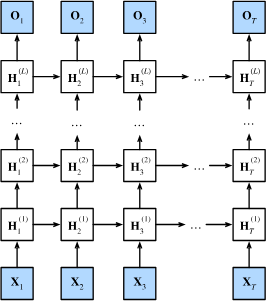

as illustrated by the above graph.
we could define the layers of the rnn as deep_num
and every hidden state is decided by the pre step hidden state and the lower layers hidden state.

let us implement this structure.

from what I understand, If the RNN is deep, let say 3 layers, then the performance of the model should be better?

but the result is a little disappointing. dont know why



In [5]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, vocab_size, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)

  def forward(self, x, h):
    h = torch.tanh(self.i2h(x) + self.h2h(h))
    return h


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size)
    self.rnn_list = nn.ModuleList([SimpleRNN(vocab_size, hidden_size) for _ in range(deep_num)])
    self.h2o = nn.Linear(hidden_size, vocab_size)
  def forward(self, x, h_prev_list):
    x = self.embedding(x)
    h_list = []
    h = self.e2h(x)
    for i in range(self.deep_num):
      h = self.rnn_list[i](h, h_prev_list[i])
      h_list.append(h)
    y = self.h2o(h)
    return y, h_list

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

I updated the VanillaRNN a little, since We dont need the output of the intermediate node in Deep RNN, so we could remove the self.h2o linear layer. and add an final linear layer in the upper layer, by doing so, we could significantly reduce the amount of the parameters in the nn.

In [6]:
def generateMiniBatch(start_idx):
  batch_inputs = []
  batch_targets = []

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [7]:
stopi = []
lossi = []

In [12]:
# Training loop
num_iterations = 2 * 1000000
p = 0
for iteration in range(num_iterations):

  if p + seq_length + 1 > len(data):
    p = 0;

  inputs, targets = generateMiniBatch(p)

  optimizer.zero_grad()

  totalloss = 0
  hprev_list = [torch.zeros(1, 1, hidden_size) for _ in range(deep_num)]  # Reset RNN memory
  for i in range(seq_length):
    input_char = inputs[:,i].unsqueeze(1)
    output_char = targets[:,i]

    predict_char, hprev_list = model(input_char, hprev_list)

    loss = criterion(predict_char.squeeze(1), output_char)
    totalloss += loss.item()

    loss.backward()
    for i in range(deep_num):
      hprev_list[i] = hprev_list[i].detach()

    for param in model.parameters():
      if param.grad is not None:
        param.grad.data.clamp_(-5, 5)

    optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss/seq_length}')
    stopi.append(iteration)
    lossi.append(totalloss/seq_length)

  p += seq_length  # Move data pointer

Iteration 0, Loss: 2.4452978420257567
Iteration 1000, Loss: 2.107041149139404
Iteration 2000, Loss: 2.0764822340011597
Iteration 3000, Loss: 2.429695224761963
Iteration 4000, Loss: 2.173118224143982
Iteration 5000, Loss: 2.2604752588272095
Iteration 6000, Loss: 2.2582942485809325
Iteration 7000, Loss: 2.0351568984985353
Iteration 8000, Loss: 2.246184592247009
Iteration 9000, Loss: 2.0501819133758543
Iteration 10000, Loss: 2.3043687915802002
Iteration 11000, Loss: 2.550799503326416
Iteration 12000, Loss: 2.5084855270385744
Iteration 13000, Loss: 2.6959645748138428


KeyboardInterrupt: 

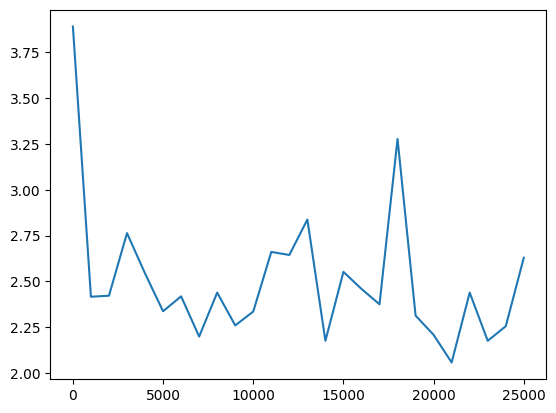

In [9]:
plt.plot(stopi, lossi)

In [10]:
# Sample from the model
def sample(model, seed_ix, n):
  h_list = [torch.zeros(1, hidden_size) for _ in range(deep_num)]
  x = torch.tensor(seed_ix, dtype=torch.long).view(1, 1)
  ixes = []

  for _ in range(n):
    outputs, h_list = model(x, h_list)
    p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    x = torch.tensor(ix, dtype=torch.long).view(1, 1)
    ixes.append(ix)

  return ixes

In [13]:
#the generated text is not as good as expected. so may need further optimize
sample_ix = sample(model, char_to_ix[data[0]], 2000)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print(f'Generated Text:\n{txt}')

Generated Text:
ertec Eis t';d'sas apeez fort.

DYen mane?
Oan ounmires dor fasser go dedr, teecreaar pringr, are s
Thato ve tarem.
Re mithond me llou moll, late, yeunt ard doiktes!;
Whpeaesweol don po lut h:
Yalde tuss oun the iV
ULRY:
N kise.
Is woven I ner;
Quray olaw en.

MEEEYLWUBTICoa nHiq you do, I wamas, waike, and.
 hade ming wapson inyt,
On mifens do miertees turn ge faelar wo shak of them.

PBtias wacersstave, bniseb
Ahe seyys 'ithy
H3fe ontedisk
Wned:
Thaud.

AM& wiur cousping febnesd.
Fl GRHCS:
AW:
I UHAKI
Gorall dared nougionss fratte briTp
OStVimh war, jo wo chill my beat me :
Bsut unou Fir, tice bap in cof ge
Ke oancot cet.

STIN:
Hlate.vess y
HUALUFCI!ruwirimad!

:
To leist'd youls tharlis the kll hy youk't abdearherss andrd meme
Ted rapeard,
I thit onCI:
Wour het in dodve ly MD, I-pcordwasill thourad ot to ham, sonlamae, ong sblay forred gliy tio nd Sumly Apeapth suy ,
Ther stal, so-d over the gand thy asts
Tila ca, stesss paljAml andivet anc'en mil'?
The?
We framange